In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import numpy as np

## Introdução

Este projeto tem como objetivo principal a implementação e avaliação de classificadores baseados em Deep Learning para o reconhecimento de sons urbanos.

O problema de classificação abordado foca-se no conjunto de dados UrbanSound8K, um dataset de referência que contém 8.732 excertos sonoros rotulados, categorizados em 10 classes distintas de sons do quotidiano urbano (como sirenes, ladrar de cães, entre outros). O desafio consiste em desenvolver modelos capazes de identificar corretamente a classe a que pertence um áudio desconhecido.

Para responder a este desafio, foram implementadas duas arquiteturas de redes neuronais distintas, permitindo uma análise comparativa de diferentes abordagens de modelação:

1. **Multi-Layer Perceptron (MLP):** Um classificador baseado numa rede neuronal feedforward densa, que opera sobre vetores de características estatísticas extraídas do áudio. Esta abordagem foca-se na classificação baseada no timbre e conteúdo espectral médio.

2. **Convolutional Neural Network (CNN 2D)**: Um classificador baseado em redes convolucionais bidimensionais, que processa o som como uma "imagem" (Espectrogramas Mel). Esta abordagem permite capturar padrões complexos na estrutura temporal e frequencial do som, superando as limitações da representação estatística do MLP.

Estrutura do Projeto: Para garantir a organização do desenvolvimento, o trabalho encontra-se dividido em quatro notebooks:

- Principal: Análise exploratória (EDA) e pré-processamento global dos dados.

- MLP: Implementação, otimização e avaliação do classificador Multi-Layer Perceptron.

- CNN: Desenvolvimento e treino do modelo convolucional baseado em espectrogramas.

- DeepFool: Testes de robustez e aplicação de ataques adversários aos modelos.


## Análise Exploratória dos Dados

Nesta secção, vamos:
1.  Verificar a integridade dos metadados e a correspondência com os ficheiros de áudio reais.
2.  Analisar o balanceamento das 10 classes.
3.  Investigar a distribuição das amostras pelos 10 *folds* originais.
4.  Analisar as durações dos áudios, o que influenciará as decisões de pré-processamento.

In [ ]:
# Leitura do ficheiro
metadata_path = "UrbanSound8K/metadata/UrbanSound8K.csv"
df = pd.read_csv(metadata_path)
print(df.head())
print(df['class'].value_counts())

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  
class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64


In [ ]:
#Garantir tipos corretos
df.dtypes

slice_file_name     object
fsID                 int64
start              float64
end                float64
salience             int64
fold                 int64
classID              int64
class               object
dtype: object

#### Verificar duplicados

In [ ]:
dupes = df.duplicated()
print(f"Duplicados: {dupes.sum()}")

Duplicados: 0


#### Verificar Valores Nulos

In [ ]:
print(df.isnull().sum())

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64


In [ ]:
audio_dir = "UrbanSound8K/audio"

# Criar caminho absoluto do ficheiro
df['file_path'] = df.apply(
    lambda row: os.path.join(audio_dir, f"fold{row['fold']}", row['slice_file_name']),
    axis=1
)

#### Verificar ficheiros do metadata inexistentes nos arquivos de aúdio

In [ ]:
missing = df[~df['file_path'].apply(os.path.exists)]
print(f" Ficheiros em falta: {len(missing)}")

 Ficheiros em falta: 0


#### Verificar ficheiros a mais nos arquivos de aúdio (que não se encontram no metadata)

In [ ]:
# Lista de ficheiros de aúdio nos arquivos
all_audio_files = []
for root, dirs, files in os.walk(audio_dir):
    for f in files:
        if f.endswith(".wav"):
            all_audio_files.append(os.path.join(root, f))
            
# Converter caminhos do metadata em absolutos para comparação direta
metadata_files = df['file_path'].tolist()

# Identificar ficheiros que estão no diretório mas não no metadata
extra_files = [f for f in all_audio_files if f not in metadata_files]

print(f"Ficheiros a mais (não listados no metadata): {len(extra_files)}")
if len(extra_files) > 0:
    print("Exemplos:")
    for f in extra_files[:10]:
        print(f"  - {f}")

Ficheiros a mais (não listados no metadata): 0


**Validação da Integridade:**
As verificações confirmaram que os metadados são consistentes com os ficheiros presentes no disco. Não foram detetados ficheiros em falta nem ficheiros "extra" não catalogados, garantindo a fiabilidade do dataset para as etapas seguintes.

#### Distribuição de classes

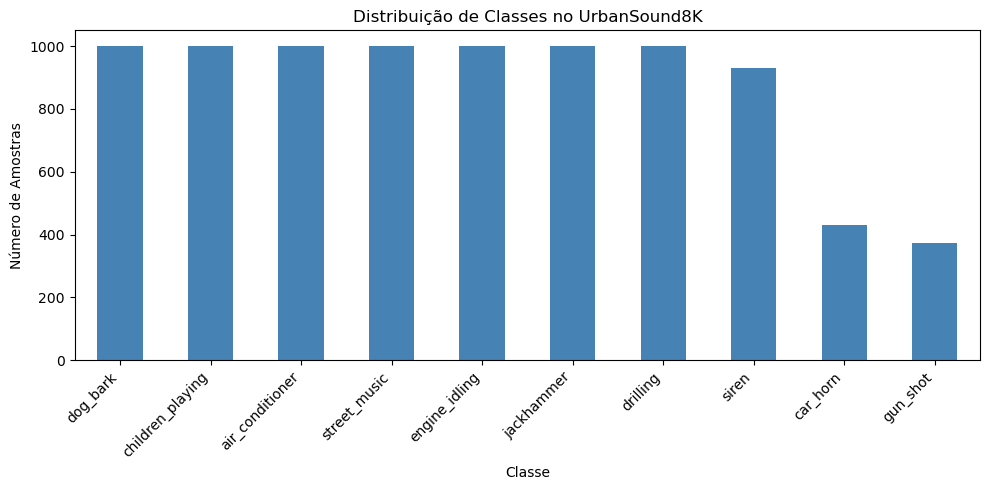

In [ ]:
#Distribuição de classes
plt.figure(figsize=(10, 5))
df['class'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Distribuição de Classes no UrbanSound8K')
plt.xlabel('Classe')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Análise de Balanceamento:**
Observamos um ligeiro desequilíbrio nas classes. Enquanto classes como *children_playing*, *dog_bark* e *street_music* têm cerca de 1000 amostras, outras como *gun_shot* e *car_horn* têm significativamente menos (~400).
Este desequilíbrio justifica a necessidade de técnicas de balanceamento durante o treino, como o uso de **SMOTE**, para evitar que o modelo enviese a favor das classes maioritárias.

#### Distribuição de entradas por fold

class  air_conditioner  car_horn  children_playing  dog_bark  drilling  \
fold                                                                     
1                  100        36               100       100       100   
2                  100        42               100       100       100   
3                  100        43               100       100       100   
4                  100        59               100       100       100   
5                  100        98               100       100       100   
6                  100        28               100       100       100   
7                  100        28               100       100       100   
8                  100        30               100       100       100   
9                  100        32               100       100       100   
10                 100        33               100       100       100   

class  engine_idling  gun_shot  jackhammer  siren  street_music  
fold                                         

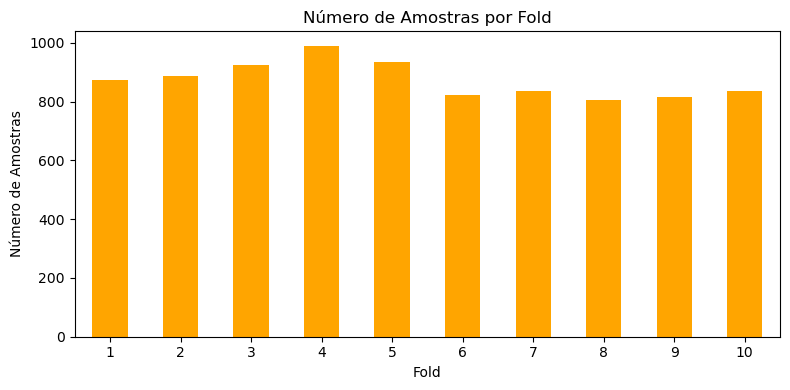

In [ ]:
print(df.groupby('fold')['class'].value_counts().unstack(fill_value=0))
print(df.describe())

plt.figure(figsize=(8, 4))
df['fold'].value_counts().sort_index().plot(kind='bar', color='orange')
plt.title('Número de Amostras por Fold')
plt.xlabel('Fold')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


#### Distribuição de classes por fold

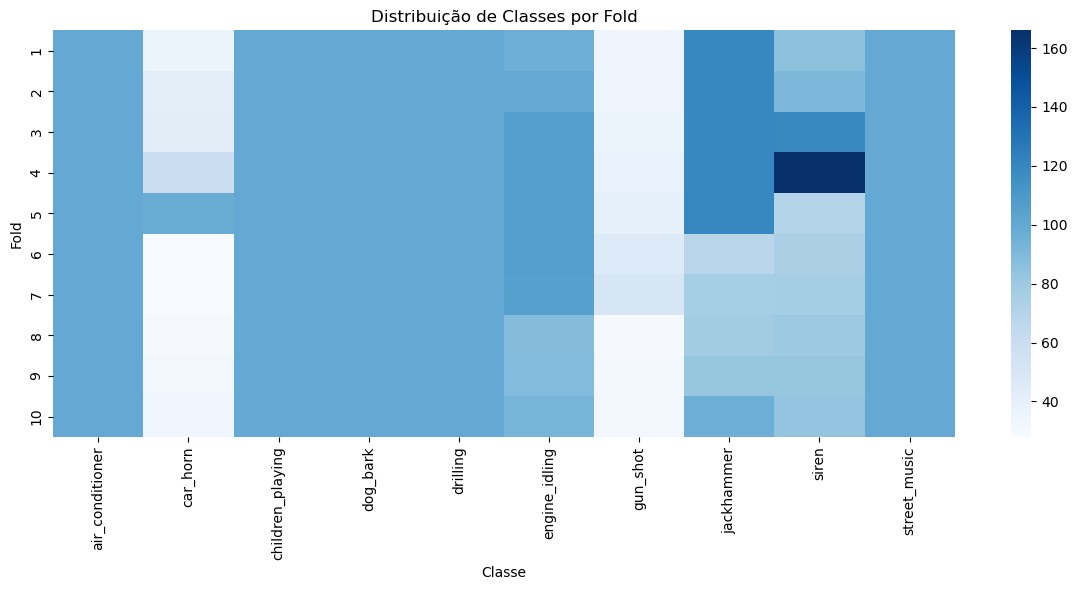

In [ ]:
fold_class_counts = df.groupby(['fold', 'class']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(fold_class_counts, cmap='Blues', annot=False)
plt.title('Distribuição de Classes por Fold')
plt.xlabel('Classe')
plt.ylabel('Fold')
plt.tight_layout()
plt.show()

**Análise da Estrutura dos Folds:**
A visualização da distribuição de classes por *fold* revela que os *folds* originais não mantêm a mesma proporção de classes. Alguns *folds* podem ter muito poucas amostras de uma classe específica.
Apesar disso, manteremos a estrutura de 10-Folds original para garantir a comparabilidade com outros trabalhos na literatura que utilizam o *UrbanSound8K*.

#### Duração média por classe

C:\Users\eduar\AppData\Local\Temp\ipykernel_6524\615685534.py:1: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  df['duration'] = df['file_path'].apply(lambda x: librosa.get_duration(filename=x))


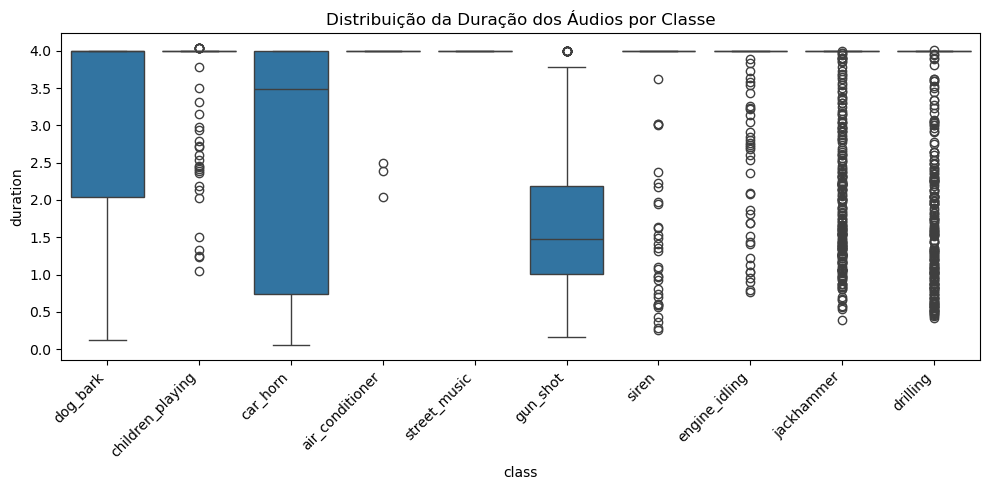

In [ ]:
df['duration'] = df['file_path'].apply(lambda x: librosa.get_duration(filename=x))
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='class', y='duration')
plt.xticks(rotation=45, ha='right')
plt.title('Distribuição da Duração dos Áudios por Classe')
plt.tight_layout()
plt.show()

**Análise da Duração dos Áudios:**
O *boxplot* mostra que a duração dos clipes varia consideravelmente. A maioria das classes tende para o máximo de 4 segundos, mas a classe **`gun_shot`** destaca-se por ter durações consistentemente muito curtas (< 1s).
**Impacto no Pré-processamento:** Como os modelos (MLP e CNN) exigem entradas de tamanho fixo, será necessário aplicar técnicas de:
* **Padding:** Preencher com silêncio os sons curtos (como *gun_shot*) até atingirem 4s.
* **Truncating:** Cortar qualquer áudio que exceda ligeiramente os 4s.
Isto garantirá que todos os vetores de entrada tenham a mesma dimensão temporal.

### Visualização Acústica: Espectrogramas Mel e MFCCs

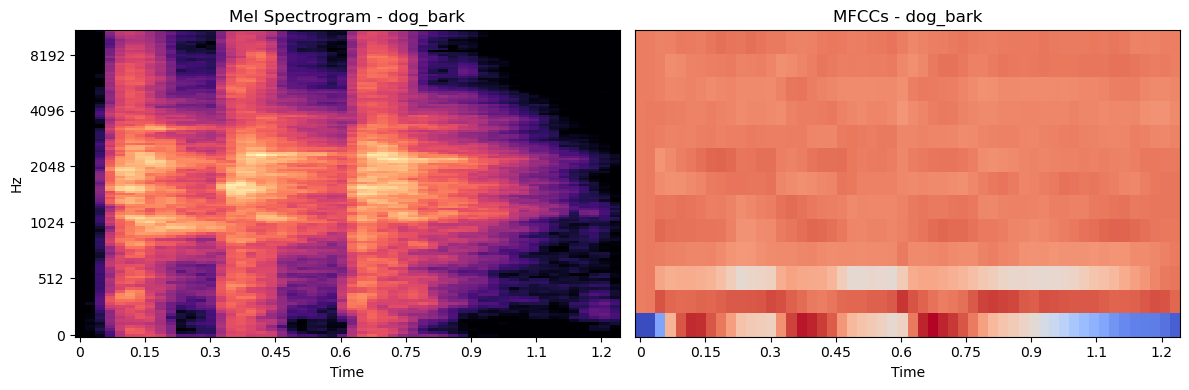

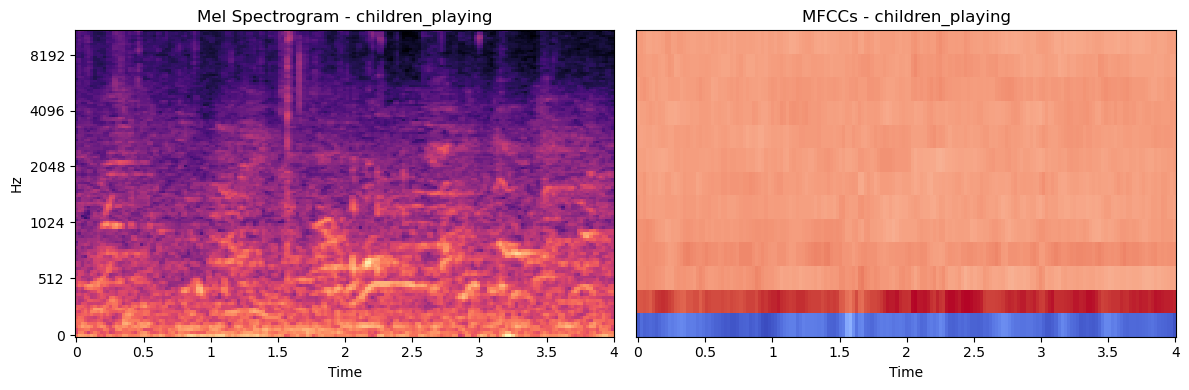

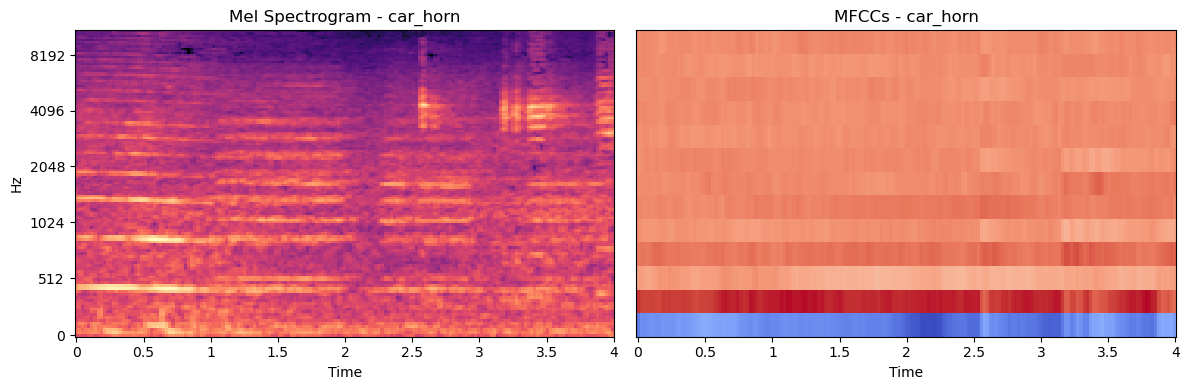

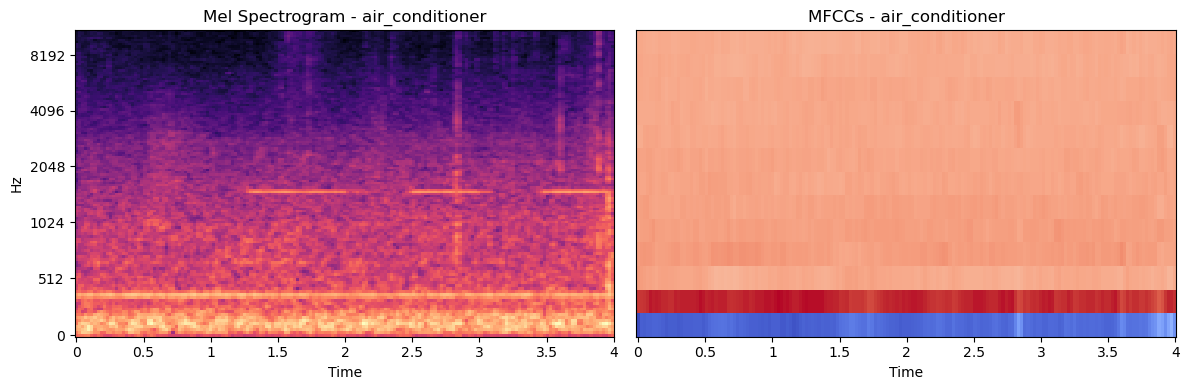

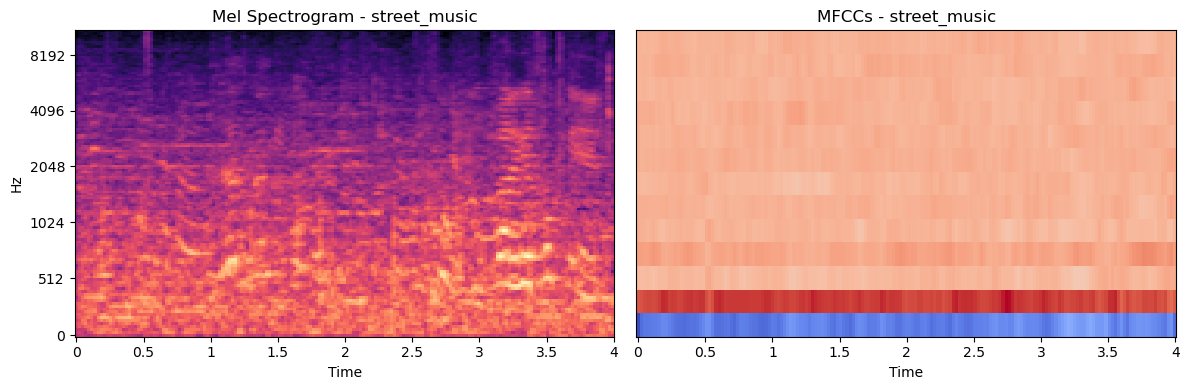

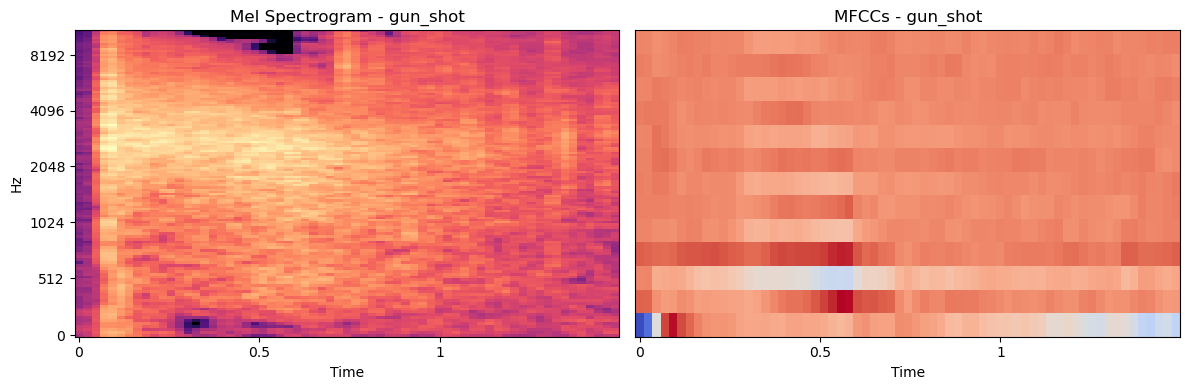

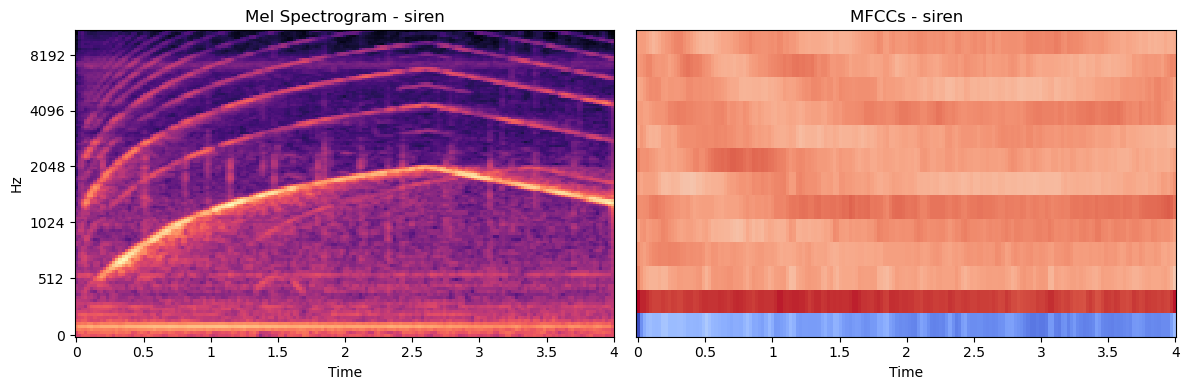

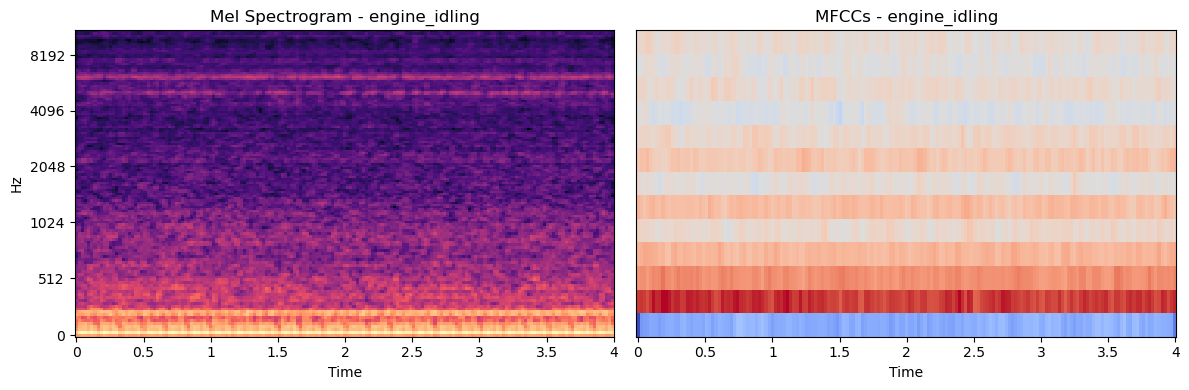

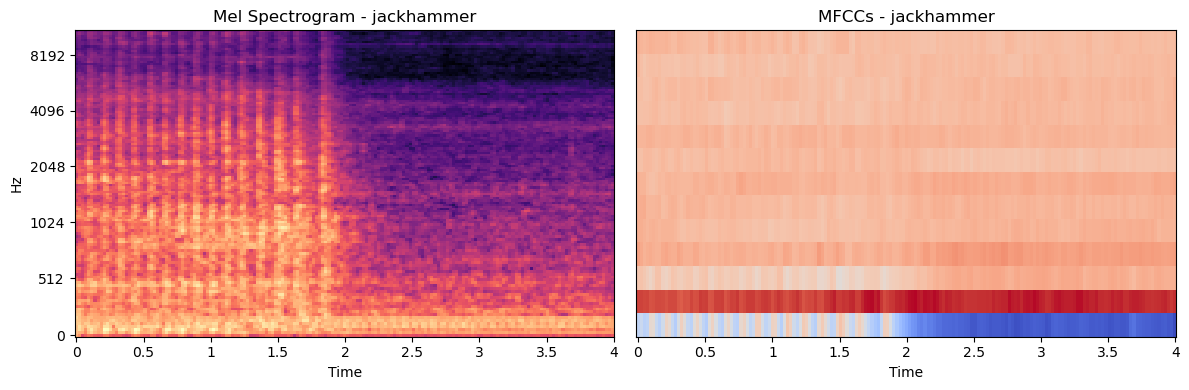

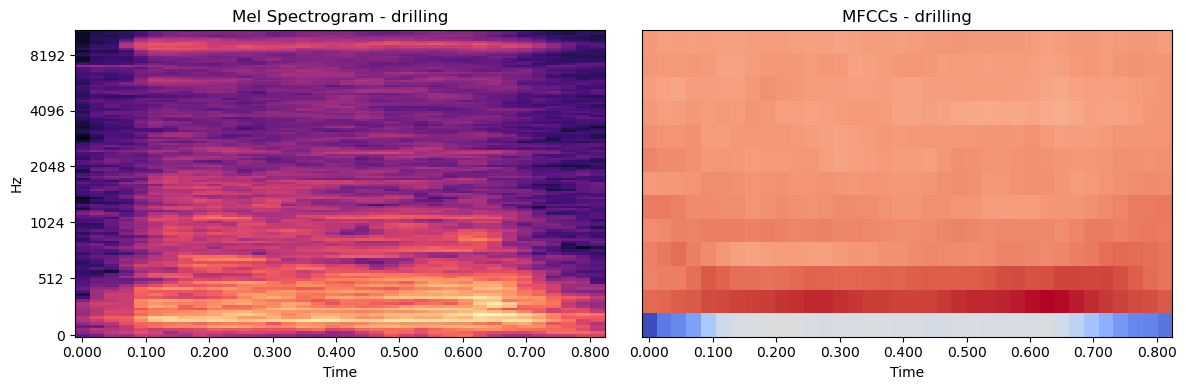

In [ ]:
for classe in df['class'].unique():
    sample = df[df['class'] == classe].sample(1, random_state=42).iloc[0]
    y, sr = librosa.load(sample['file_path'], sr=22050)
    
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel), sr=sr, n_mfcc=13)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', ax=ax[0])
    ax[0].set_title(f'Mel Spectrogram - {classe}')
    
    librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
    ax[1].set_title(f'MFCCs - {classe}')
    
    plt.tight_layout()
    plt.show()

1. **Espectrograma Mel:** mostra a energia sonora ao longo do tempo e da frequência, evidenciando sons curtos e impactantes, como dog bark ou jackhammer, por picos verticais, enquanto sons contínuos, como engine idling, formam linhas horizontais estáveis.  

2. **MFCCs** capturam o timbre e a textura acústica, revelando padrões contínuos para sons estacionários (street music) e variações abruptas para sons impulsivos (gun shot). Assim, espectrogramas Mel destacam diferenças temporais e de intensidade, enquanto os MFCCs evidenciam assinaturas tímbricas essenciais.

## Modelos

Concluída a exploração e visualização dos dados, avançamos agora para os restantes notebooks do projeto: MLP, CNN e DeepFool, onde são desenvolvidos e avaliados os modelos, bem como analisada a sua robustez.